In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch

import osmnx as ox
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
import geopandas
from geopandas.tools import sjoin
from pyproj import Proj, transform
from geopy.distance import distance
from shapely.geometry import LineString, Point, LinearRing


from dask import dataframe
import multiprocessing
from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

/work/sagarj/miniconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/work/sagarj/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [3]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [45]:
roads = gpd.read_file('../Data/GreaterLondon/edges/edges.shp')

In [46]:
roads.head()

,access,area,bridge,est_width,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,None,None,370068561,residential,None,0,None,17.609,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"LINESTRING (715931.281 5710314.614, 715917.030..."
1,None,None,None,None,95944707,residential,None,0,None,68.247,20 mph,Galsworthy Close,False,10780432,None,None,95944704,None,None,"LINESTRING (715964.413 5710256.225, 715934.225..."
2,None,None,None,None,95944671,residential,None,0,None,41.109,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"LINESTRING (715885.341 5710277.855, 715917.030..."
3,None,None,None,None,277489,residential,None,0,None,29.564,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"LINESTRING (695323.706 5722787.895, 695294.102..."
4,None,None,None,None,277490,residential,None,0,None,80.433,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"LINESTRING (695216.776 5722810.611, 695286.927..."


In [5]:
roads['geometry'] = roads['geometry'].buffer(10)

In [6]:
roads.head()

,access,area,bridge,est_width,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,None,None,370068561,residential,None,0,None,17.609,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"POLYGON ((715922.931 5710296.123, 715922.112 5..."
1,None,None,None,None,95944707,residential,None,0,None,68.247,20 mph,Galsworthy Close,False,10780432,None,None,95944704,None,None,"POLYGON ((715928.246 5710270.726, 715927.388 5..."
2,None,None,None,None,95944671,residential,None,0,None,41.109,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"POLYGON ((715910.637 5710311.886, 715911.422 5..."
3,None,None,None,None,277489,residential,None,0,None,29.564,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"POLYGON ((695293.489 5722779.731, 695292.514 5..."
4,None,None,None,None,277490,residential,None,0,None,80.433,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"POLYGON ((695287.856 5722799.038, 695292.917 5..."


In [7]:
roads.crs

{'init': 'epsg:32630'}

In [8]:
roads_WGS84 = roads.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
roads_WGS84.head()

,access,area,bridge,est_width,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,None,None,370068561,residential,None,0,None,17.609,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"POLYGON ((0.11122 51.50249, 0.11121 51.50248, ..."
1,None,None,None,None,95944707,residential,None,0,None,68.247,20 mph,Galsworthy Close,False,10780432,None,None,95944704,None,None,"POLYGON ((0.11128 51.50226, 0.11127 51.50227, ..."
2,None,None,None,None,95944671,residential,None,0,None,41.109,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"POLYGON ((0.11106 51.50264, 0.11107 51.50264, ..."
3,None,None,None,None,277489,residential,None,0,None,29.564,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"POLYGON ((-0.17868 51.62211, -0.17870 51.62211..."
4,None,None,None,None,277490,residential,None,0,None,80.433,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"POLYGON ((-0.17875 51.62228, -0.17868 51.62228..."


In [10]:
# shp_roads = fiona.open('../Data/Geo_Data/geo/london_wards.shp')

# shp_roads.crs

from geopandas.tools import sjoin

In [11]:
len(roads)

161911

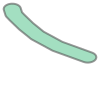

In [12]:
roads_WGS84.iloc[20]['geometry']

In [13]:
# samples = gpd.read_file('../Data/GreaterLondon/edges/samples.shp')

In [14]:
mapillary_points = pd.read_csv('../Data/Mappilary_points_merged.csv')

In [15]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv',engine='python')

In [16]:
mapillary_points.head()

,Unnamed: 0,Imgkey,Sky,Building,Pole,Road_Marking,Road,Pavement,Tree,Sign_Symbol,...,Vehicle,Pedestrian,Bike,Unnamed: 0.1,captureTime,isPano,lat,long,long_lat_string,geometry
0,0,wE0jAFaY7S7kBlobMy3nPA,0.288501,0.104387,0.031655,0.006545,0.334103,0.012228,0.094468,0.006325,...,0.102205,0.006343,0.000006,155358,2017-01-09T11:16:58.080Z,False,51.458700,-0.195153,-0.1952_51.4587,POINT (-0.1951528 51.4586997)
1,1,k_syhXZRKg-blx5cCvFdBg,0.168970,0.000347,0.004676,0.015434,0.240914,0.104091,0.455197,0.000156,...,0.000006,0.000087,0.000000,331930,2019-08-20T20:07:23.000Z,False,51.395208,0.007908,0.0079_51.3952,POINT (0.0079077 51.3952076)
2,2,iVXnlg3PQMPspbTFqRD9eA,0.021730,0.146528,0.012488,0.034340,0.262760,0.138669,0.303953,0.000434,...,0.032488,0.041644,0.002297,92492,2019-06-09T17:11:34.567Z,False,51.532153,0.055075,0.0551_51.5322,POINT (0.0550746 51.5321528)
3,3,amVTOx7uE0GuMkeN2ECC3w,0.249045,0.156707,0.001586,0.000017,0.146730,0.073339,0.352066,0.000012,...,0.017598,0.000839,0.001007,205329,2015-04-15T11:11:25.227Z,False,51.522573,-0.036350,-0.0363_51.5226,POINT (-0.0363496 51.5225733)
4,4,46aeChblLDzqF3p4UjXb7g,0.061244,0.003218,0.000405,0.000527,0.147847,0.052610,0.707002,0.000764,...,0.004624,0.000382,0.000000,121677,2016-08-29T16:15:48.000Z,False,51.622794,-0.136517,-0.1365_51.6228,POINT (-0.1365167 51.6227944)


In [17]:
m = Basemap(
    projection='merc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


In [18]:
treeLocations = []

for index , row in tree_data.iterrows():
#     point = Point(m(row['longitude'], row['latitude']))
    point = Point(row['longitude'], row['latitude'])
#     point = Point(transform(inProj,outProj,row['longitude'], row['latitude']))
    treeLocations.append(point)

print(treeLocations[1])

tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))

POINT (0.1391226851333678 51.58566970615966)


In [19]:
mapLocations = {}
for index , row in mapillary_points.iterrows():
#     point = Point(m(row['long'], row['lat']))
    point = Point(row['long'], row['lat'])
    mapLocations[row['Imgkey']] = point

# map_points = pd.Series(mapLocations)
# map_data_points = MultiPoint(list(map_points.values))

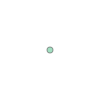

In [20]:
mapLocations[list(mapLocations.keys())[1]]

In [21]:
tree_gdf = geopandas.GeoDataFrame(tree_data, geometry=geopandas.points_from_xy(tree_data.longitude, tree_data.latitude))

In [22]:
joined_trees = sjoin(tree_gdf,roads_WGS84,how='left')

/work/sagarj/miniconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [23]:
roads_WGS84.head()

,access,area,bridge,est_width,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,None,None,370068561,residential,None,0,None,17.609,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"POLYGON ((0.11122 51.50249, 0.11121 51.50248, ..."
1,None,None,None,None,95944707,residential,None,0,None,68.247,20 mph,Galsworthy Close,False,10780432,None,None,95944704,None,None,"POLYGON ((0.11128 51.50226, 0.11127 51.50227, ..."
2,None,None,None,None,95944671,residential,None,0,None,41.109,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"POLYGON ((0.11106 51.50264, 0.11107 51.50264, ..."
3,None,None,None,None,277489,residential,None,0,None,29.564,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"POLYGON ((-0.17868 51.62211, -0.17870 51.62211..."
4,None,None,None,None,277490,residential,None,0,None,80.433,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"POLYGON ((-0.17875 51.62228, -0.17868 51.62228..."


In [24]:
tree_gdf.head()

,gla_id,borough,species_name,common_name,display_name,load_date,easting,northing,longitude,latitude,geometry
0,glaid_0,Barking,Acer pseudoplatanus 'brilliantissimum',NaN,Maple,20180214,548320.0,189593.0,0.139454,51.585695,POINT (0.13945 51.58570)
1,glaid_1,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548297.0,189590.0,0.139123,51.585670,POINT (0.13912 51.58567)
2,glaid_2,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548289.0,189592.0,0.139004,51.585689,POINT (0.13900 51.58569)
3,glaid_3,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548298.0,189597.0,0.139134,51.585732,POINT (0.13913 51.58573)
4,glaid_4,Barking,Robinia pseudoacacia,NaN,Black Locust,20180214,548308.0,189607.0,0.139288,51.585819,POINT (0.13929 51.58582)


In [25]:
joined_trees.head()

,gla_id,borough,species_name,common_name,display_name,load_date,easting,northing,longitude,latitude,...,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width
0,glaid_0,Barking,Acer pseudoplatanus 'brilliantissimum',NaN,Maple,20180214,548320.0,189593.0,0.139454,51.585695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,glaid_1,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548297.0,189590.0,0.139123,51.585670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,glaid_2,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548289.0,189592.0,0.139004,51.585689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,glaid_3,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548298.0,189597.0,0.139134,51.585732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,glaid_4,Barking,Robinia pseudoacacia,NaN,Black Locust,20180214,548308.0,189607.0,0.139288,51.585819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
len(joined_trees), len(tree_gdf) , len(roads_WGS84)

(783388, 726934, 161911)

In [28]:
joined_trees.columns

Index(['gla_id', 'borough', 'species_name', 'common_name', 'display_name',
       'load_date', 'easting', 'northing', 'longitude', 'latitude', 'geometry',
       'index_right', 'access', 'area', 'bridge', 'est_width', 'from',
       'highway', 'junction', 'key', 'lanes', 'length', 'maxspeed', 'name',
       'oneway', 'osmid', 'ref', 'service', 'to', 'tunnel', 'width'],
      dtype='object')

In [30]:
# %store joined_trees

Stored 'joined_trees' (GeoDataFrame)


In [33]:
len(tree_gdf['gla_id'].unique()),len(joined_trees['gla_id'].unique()),len(joined_trees['osmid'].unique()),

(726934, 726934, 40258)

In [38]:
inaccessible_trees = joined_trees[joined_trees['osmid'].isnull()]

In [39]:
len(inaccessible_trees)

379190

In [40]:
accessible_trees = joined_trees[joined_trees['osmid'].notnull()]

In [41]:
len(accessible_trees)

404198

In [42]:
%store inaccessible_trees
%store accessible_trees

Stored 'inaccessible_trees' (GeoDataFrame)
Stored 'accessible_trees' (GeoDataFrame)


In [ ]:
# %store -r inaccessible_trees

In [43]:
# inaccessible_trees.to_file("scratchpad/inaccessible_trees.shp")

In [44]:
# accessible_trees.to_file("scratchpad/accessible_trees.shp")

In [ ]:
def distKm(Points_tuple):
    return distance(Points_tuple[0], Points_tuple[1]).km


def pointsCount(geometry , points):
    within = []
    without = []
    for p in points: 
        if p.within(geometry):
            within.append(p)
        else:
            without.append(p)
    return within, without

def approxPointsCount(geometry, points):
    bufferdist = 0.01
    poly = geometry.buffer(bufferdist)
    centroid = poly.centroid.xy
    within = []
    for p in points: 
        if distance(p,centroid) <= bufferdist:
            within.append(p)
    return pd.Series(within)

def filterMappilary(geometry , pointsKeys):
    within = []
    for k in pointsKeys: 
        p = pointsKeys[k]
        if p.within(geometry):
            within.append(k)
    return within

In [ ]:
print(multiprocessing.cpu_count())

In [ ]:
roads_dd = dataframe.from_pandas(roads_WGS84,npartitions=2*multiprocessing.cpu_count())

In [ ]:
dir(roads_dd['geometry'])

In [ ]:
# within  = roads_WGS84[1000:1020]['geometry'].progress_apply(pointsCount, args = [tree_points])
# within

In [ ]:
within_trees , without_trees  = roads_dd.map_partitions(lambda df:df['geometry'].apply(pointsCount, args = [tree_points]), meta=pd.Series('list')).compute(scheduler='processes')

In [ ]:
%store within_Trees

In [ ]:
# %store within_trees
%store -r within_trees

In [ ]:
roads_WGS84['Trees'] = 0

In [ ]:
roads_WGS84.iloc[4048]

In [ ]:
for index, row in roads_WGS84.iterrows():
    roads_WGS84.at[index,'trees'] = len(within_trees[index])

In [ ]:
# %store roads_WGS84

In [ ]:
roads_filtered = roads_WGS84[roads_WGS84['trees']>10]

In [ ]:
len(roads_filtered)

In [ ]:
roads_filtered_dd = dataframe.from_pandas(roads_filtered,npartitions=2*multiprocessing.cpu_count())

In [ ]:
np.median(roads_WGS84['trees'])

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Trees per Road segment')
plt.ylabel('Frequency')
# plt.axvline(thresh_low, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(roads_filtered['trees'], 100, facecolor='g', alpha=0.75)

In [ ]:
# within_mp  = roads_filtered_dd.map_partitions(lambda df:df['geometry'].progress_apply(filterMappilary, args = [mapLocations]), meta=pd.Series('list')).compute(scheduler='processes')

In [ ]:
# %store within_mp
store -r within_mp

In [ ]:
# within_mp

In [ ]:
# roads_filtered['Mappilary'] = 0.0

In [ ]:
for k in within_mp.index:
    if len(within_mp[k]) > 0:
        map_trees = mapillary_points[mapillary_points['Imgkey'].isin(within_mp[k])]
        roads_WGS84.at[k,'Mappilary_trees'] = np.sum(map_trees['Tree'])+0.000001
        roads_WGS84.at[k,'Mappilary_samples'] = len(map_trees)

In [ ]:
len(roads_WGS84)

In [ ]:
final_roads = roads_WGS84[roads_WGS84[['Mappilary_trees', 'Mappilary_samples']].notnull().all(1)]

In [ ]:
final_roads = final_roads[final_roads['trees'] > 10 ] 

In [ ]:
len(final_roads)

In [ ]:
# final_roads_meters = final_roads.to_crs("+proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
# final_roads_meters.iloc[1000].geometry

In [ ]:
final_roads['Tree_density'] = 0.00001
final_roads['Tree_pixel_density'] = 0.00001

In [ ]:
minValue = min(final_roads['Mappilary_trees'])
print minValue

In [ ]:
for index , row in final_roads.iterrows():
    tree_density =  np.log(float(row['trees'])/float(row['length'])) 
    pixel_density = np.log(float(row['Mappilary_trees'])/float(row['length']))
#     print tree_density , pixel_density
    final_roads.at[index,'Tree_density'] = tree_density
    final_roads.at[index,'Tree_pixel_density'] = pixel_density

In [ ]:
final_roads.head()

In [ ]:
# %store final_roads

In [ ]:
from scipy.stats import pearsonr
corr = pearsonr(final_roads['Tree_density'],final_roads['Tree_pixel_density'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=final_roads['Tree_pixel_density'], y=final_roads['Tree_density'], kind='regression',height=15);
plt.xlabel('ln(Tree pixels per km)')
plt.ylabel('ln(Trees per km)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [ ]:
final_roads[:1000]

In [ ]:
final_roads['samples_per_km'] = 0.0
for i , row in final_roads.iterrows():
    density = float(row['Mappilary_samples'])/float(row['length'])
    final_roads.at[i,'samples_per_km'] = density

In [ ]:
final_roads['decile'] = pd.qcut(final_roads['Mappilary_samples'], q=10, precision=0)

In [ ]:
corrs = []
bins = []
for name, group in final_roads.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['Tree_density'],group['Tree_pixel_density'])
    corrs.append(corr)

In [ ]:
corrs

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Roads binned by Mapillary samples",fontsize = 25)
plt.ylabel("Correlation of Mappilary green index with ln(treepixels/km)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['name'], xy=(r["Tree_density"], r["Tree_pixel_density"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

In [ ]:
corrs_density = []
bins_density = []
for name, group in final_roads.groupby('decile'):
    bins_density.append(name)
    corr = pearsonr(group['Tree_density'],group['Tree_pixel_density'])

    print corr
    sns.set(font_scale=2) 
    ax = sns.jointplot(x="Tree_density", y="Tree_pixel_density", data=group,kind='regression',height=15);
    plt.xlabel('ln(Trees per km)')
    plt.ylabel('ln(Tree pixels square km)')
    ax.annotate(pearsonr)
    for row in group.iterrows():
        ann(row)
    corrs_density.append(corr)